In [1]:
import fmrai
import importlib
from tqdm import tqdm
import torch

In [3]:
from fmrai.instrument import unwrap_proxy
import torch

# with torch.no_grad():
with fmrai.fmrai():
    y = 0
    for _ in range(1000000):
        x = torch.randn((100, 100))
        y = y + x
        
# print(unwrap_proxy(y))

KeyboardInterrupt: 

In [10]:
import gc
gc.collect()

0

In [8]:
del x

In [2]:
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained('bert-base-uncased').cuda()
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
dataset = load_dataset('bookcorpus', streaming=True)

In [3]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

batch_size = 32
small_dataset = dataset['train'].take(8192)
small_dataset_tokenized = small_dataset.map(
    lambda x: tokenizer(x['text'], padding='longest', return_tensors='pt'),
    batched=True,
    batch_size=batch_size
).remove_columns(['text'])

collator = DataCollatorWithPadding(tokenizer, padding='longest', return_tensors='pt')
loader = DataLoader(small_dataset_tokenized, batch_size=batch_size, collate_fn=collator)

0it [00:00, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
256it [04:15,  1.00it/s]
/home/jacob/Projects/fmrai/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


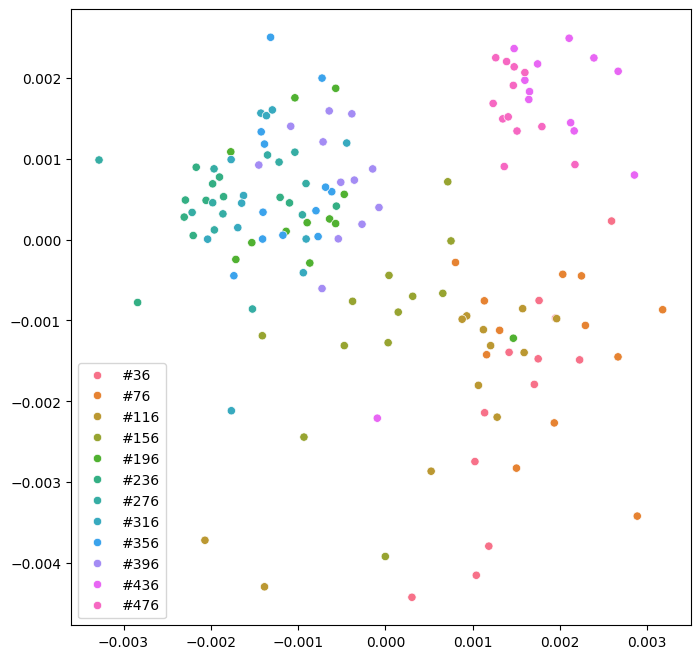

In [4]:
# import tracemalloc
# tracemalloc.start()

from fmrai.instrument import instrument_model

# import fmrai.analysis.attention
# importlib.reload(fmrai.analysis.attention)
from fmrai.analysis.attention import AttentionHeadClusterAnalyzer

with fmrai.fmrai():
    m = instrument_model(model)
    # m = model
    
    analyzer = AttentionHeadClusterAnalyzer()
# with torch.no_grad():
    for batch in tqdm(loader):
        with analyzer.track_batch():
            m(**batch.to(model.device))
        
    analyzer.analyze().plot()
    del analyzer
    
# snapshot = tracemalloc.take_snapshot()

In [30]:
import functools
import operator
shapes = [tuple(t.shape) for mp in analyzer.tracker._cmaps for t in mp.data.values()]
sum([functools.reduce(operator.mul, s, 1) for s in shapes])

413180928

In [10]:
import gc
gc.collect()

0

In [7]:
top_stats = snapshot.statistics('lineno')

NameError: name 'snapshot' is not defined

In [6]:
for stat in top_stats[:10]:
    print(stat)

<frozen importlib._bootstrap_external>:729: size=14.0 MiB, count=110782, average=133 B
<frozen abc>:106: size=796 KiB, count=1559, average=523 B
<frozen importlib._bootstrap>:241: size=720 KiB, count=8092, average=91 B
/home/jacob/Projects/fmrai/.venv/lib/python3.11/site-packages/torch/_dynamo/allowed_functions.py:181: size=669 KiB, count=11814, average=58 B
/home/jacob/Projects/fmrai/.venv/lib/python3.11/site-packages/torch/_dynamo/allowed_functions.py:57: size=512 KiB, count=2, average=256 KiB
/home/jacob/Projects/fmrai/.venv/lib/python3.11/site-packages/torch/_dynamo/allowed_functions.py:183: size=432 KiB, count=2665, average=166 B
/home/jacob/Projects/fmrai/.venv/lib/python3.11/site-packages/matplotlib/_docstring.py:40: size=429 KiB, count=124, average=3545 B
/usr/lib/python3.11/inspect.py:3017: size=323 KiB, count=4832, average=68 B
/usr/lib/python3.11/dataclasses.py:433: size=261 KiB, count=2911, average=92 B
/usr/lib/python3.11/asyncio/sslproto.py:275: size=256 KiB, count=2, ave